# WeGo Public Transit
[WeGo Public Transit](https://www.wegotransit.com/) is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

The data for this project can be downloaded from [here](https://drive.google.com/file/d/1iM4WjC9k3EXHPNc6q4AwDh_MEIpXvfMD/view?usp=sharing).

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. 

There are two main variables you will be studying in this project, headway deviation and adherence.

**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

Another important variable is **adherence**, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. **Note:** When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
wego = pd.read_csv(r'C:\Users\jenni\OneDrive\Desktop\DA12\Projects\Python\wego-python-da12-python-spice-lattes\data\Headway Data, 8-1-2023 to 9-30-2023.csv')

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [4]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                350329 non-null  int64  
 1   SERVICE_ABBR               350329 non-null  int64  
 2   ADHERENCE_ID               350329 non-null  int64  
 3   DATE                       350329 non-null  object 
 4   ROUTE_ABBR                 350329 non-null  int64  
 5   BLOCK_ABBR                 350329 non-null  int64  
 6   OPERATOR                   350329 non-null  int64  
 7   TRIP_ID                    350329 non-null  int64  
 8   OVERLOAD_ID                350329 non-null  int64  
 9   ROUTE_DIRECTION_NAME       350329 non-null  object 
 10  TIME_POINT_ABBR            350329 non-null  object 
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64
 12  TRIP_EDGE                  350329 non-null  int64  
 13  LATITUDE                   35

Goals of this project:


1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

**2. How does direction of travel, route, or location affect the headway and on-time performance?**

NOTE TO SELF: possible layered histogram for looking at the diff factors

NOTE TO SELF 2: want to see each factor individually AND how they may layer 

*Investigate adherence first (ie. on-time performance - actual departure time v scheduled departure time)

In [11]:
#group the dataset by route FIRST - see each bus route and the mean adherence for it

In [12]:
routes_adherence_df = wego.groupby(['ROUTE_ABBR']).mean(['ADHERENCE'])
routes_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
ROUTE_ABBR,,,,,,,,,,,,,,,,,,,,,
3,1.202309e+08,1.317798,1.001026e+08,307.618464,1967.163988,350813.375175,0.007103,4.445549,0.545333,36.133861,...,20.133135,0.580907,0.029303,0.203342,0.731860,0.015351,0.012573,0.010602,2.522974,13.336085
7,1.202309e+08,1.313547,1.001076e+08,739.209753,1967.504937,353122.552757,0.003606,3.993565,0.999501,36.137767,...,23.161475,0.336808,0.024021,0.189560,0.744314,0.019361,0.016894,0.015977,4.099449,12.413610
22,1.202309e+08,1.275280,1.001001e+08,2220.916522,1951.857121,349844.198428,0.003082,5.862475,0.881968,36.182597,...,30.600886,0.955867,0.024308,0.079549,0.866443,0.050156,0.066419,0.012982,3.482251,8.801047
23,1.202309e+08,1.297924,1.001005e+08,2308.833286,1827.335851,350148.296594,0.002541,4.198114,0.615061,36.206481,...,19.275453,1.053563,0.030541,0.076708,0.834450,0.017051,0.017331,0.010734,3.152254,9.631453
50,1.202309e+08,1.330554,1.001052e+08,5022.724770,1758.862697,351549.750780,0.006814,14.421658,0.509505,36.149227,...,19.753606,0.212376,0.027881,0.118108,0.838719,0.008547,0.008156,0.010949,2.881760,12.788249
52,1.202309e+08,1.305602,1.001041e+08,5208.012872,2054.115633,351885.109651,0.008491,5.250796,0.515660,36.108850,...,20.849976,0.974776,0.029970,0.193713,0.728227,0.011405,0.011003,0.012177,3.066427,14.638789
55,1.202309e+08,1.286711,1.001050e+08,5510.517500,1990.542345,352277.852108,0.008314,8.137883,0.506942,36.112883,...,13.858523,0.261038,0.024716,0.270373,0.679323,0.010493,0.010126,0.011849,2.412738,13.713638
56,1.202309e+08,1.271976,1.001052e+08,5603.721226,2029.239503,352686.363712,0.008097,9.401300,0.502532,36.236244,...,14.158662,0.149213,0.029190,0.147234,0.805748,0.010713,0.010571,0.012862,3.161385,14.529440


In [13]:
# routes_adherence_df.info() #see what columns I have

In [14]:
routes_adherence_df = routes_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
routes_adherence_df.head(20)

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_ABBR,,,,,,,
3,-3.761491,19.523403,20.133135,0.580907,0.029303,0.203342,0.731860
7,-3.346555,22.785186,23.161475,0.336808,0.024021,0.189560,0.744314
22,-1.138107,29.992722,30.600886,0.955867,0.024308,0.079549,0.866443
23,-1.760110,18.373912,19.275453,1.053563,0.030541,0.076708,0.834450
50,-2.505022,19.528756,19.753606,0.212376,0.027881,0.118108,0.838719
52,-3.971342,19.980827,20.849976,0.974776,0.029970,0.193713,0.728227
55,-4.823302,13.581157,13.858523,0.261038,0.024716,0.270373,0.679323
56,-2.703988,13.983759,14.158662,0.149213,0.029190,0.147234,0.805748


Observe above that all routes fall within the bucket of 'on time' (-6 - 1) for avg adherence, though some routes are more on time than others. Plot later.

In [16]:
#group the dataset by route direction next 
direction_adherence_df = wego.groupby(['ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
direction_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
ROUTE_DIRECTION_NAME,,,,,,,,,,,,,,,,,,,,,
FROM DOWNTOWN,1.202309e+08,1.302261,1.001038e+08,38.444296,3853.224131,1977.008461,351605.289672,0.007702,7.585649,0.546059,...,18.185985,0.579990,0.028478,0.213146,0.723461,0.012670,0.013194,0.019942,2.493444,9.341724
TO DOWNTOWN,1.202309e+08,1.294179,1.001038e+08,38.239334,3839.862346,1921.909303,351614.877905,0.005421,7.086656,0.616388,...,19.174063,0.447773,0.027252,0.118132,0.824342,0.018191,0.017476,0.002936,3.492617,15.931242


In [17]:
direction_adherence_df = direction_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
direction_adherence_df.head()

,ROUTE_ABBR,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_DIRECTION_NAME,,,,,,,,
FROM DOWNTOWN,38.444296,-3.960287,17.673479,18.185985,0.579990,0.028478,0.213146,0.723461
TO DOWNTOWN,38.239334,-2.321804,18.772306,19.174063,0.447773,0.027252,0.118132,0.824342


Observe above that 'FROM DOWNTOWN' is generally less on time than toward downtown. May not need a plot here

In [19]:
#group the dataset by location next - location defined by block_abbr (the section/block of the route that the given stop is on)
block_adherence_df = wego.groupby(['BLOCK_ABBR']).mean(['ADHERENCE'])
block_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
BLOCK_ABBR,,,,,,,,,,,,,,,,,,,,,
300,1.202309e+08,1.451765,1.001059e+08,3.000000,2235.182145,350670.824376,0.008995,4.040926,0.591747,36.146048,...,22.290352,0.322731,0.034630,0.217675,0.711716,0.018327,0.011631,0.014392,2.105501,12.161010
301,1.202309e+08,1.500168,1.001052e+08,3.000000,2161.809195,350756.834119,0.011283,4.037386,0.594308,36.145802,...,17.416645,0.108538,0.029808,0.152745,0.788313,0.018188,0.013658,0.010273,2.261899,10.636161
302,1.202309e+08,1.000000,1.000935e+08,3.000000,1314.802326,350695.453488,0.000000,4.000000,0.600000,36.146895,...,14.496040,0.514990,0.008140,0.160465,0.829070,0.004651,0.011628,0.002326,2.723271,8.196581
303,1.202309e+08,1.000000,1.000934e+08,3.000000,1187.798227,350711.337830,0.005589,4.000385,0.599345,36.146891,...,20.713154,2.249422,0.013297,0.304490,0.659665,0.010407,0.006745,0.010214,2.372611,12.862884
304,1.202309e+08,1.000000,1.000914e+08,3.000000,2610.632184,350727.316092,0.028736,4.000000,0.597701,36.146895,...,11.380115,0.619389,0.033333,0.245977,0.591954,0.044828,0.025862,0.000000,2.479331,10.729167
305,1.202309e+08,1.000000,1.000935e+08,3.000000,2378.406395,350730.318205,0.002063,4.553378,0.533265,36.130587,...,20.369663,0.847533,0.042806,0.258896,0.600309,0.015988,0.011920,0.000000,2.358481,14.637555
310,1.202309e+08,1.974650,1.001217e+08,3.000000,1858.370580,350969.460307,0.007338,4.831554,0.498999,36.122417,...,26.569611,2.034319,0.022682,0.215811,0.726818,0.020680,0.018014,0.006004,3.013574,15.794721
311,1.202309e+08,1.402082,1.001060e+08,3.000000,1817.211362,350878.917784,0.004940,4.834333,0.499471,36.122370,...,21.745388,0.567716,0.012174,0.188250,0.773994,0.012174,0.010375,0.011291,2.570303,14.765873
312,1.202309e+08,2.141983,1.001243e+08,3.000000,2181.102407,351099.537332,0.000000,4.818033,0.501836,36.122836,...,26.192634,1.393152,0.013872,0.124847,0.820481,0.015504,0.013229,0.011424,2.884241,13.843137


In [20]:
# block_adherence_df.info()

In [21]:
block_adherence_df = block_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
block_adherence_df.head(20)

,ROUTE_ABBR,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
BLOCK_ABBR,,,,,,,,
300,3.000000,-3.850305,21.856318,22.290352,0.322731,0.034630,0.217675,0.711716
301,3.000000,-3.057959,17.233663,17.416645,0.108538,0.029808,0.152745,0.788313
302,3.000000,-2.877253,14.000000,14.496040,0.514990,0.008140,0.160465,0.829070
303,3.000000,-5.213002,18.503252,20.713154,2.249422,0.013297,0.304490,0.659665
304,3.000000,-5.175286,10.751437,11.380115,0.619389,0.033333,0.245977,0.591954
305,3.000000,-4.600533,19.406897,20.369663,0.847533,0.042806,0.258896,0.600309
310,3.000000,-3.957469,24.430098,26.569611,2.034319,0.022682,0.215811,0.726818
311,3.000000,-3.699363,21.223587,21.745388,0.567716,0.012174,0.188250,0.773994
312,3.000000,-2.837090,24.921549,26.192634,1.393152,0.013872,0.124847,0.820481


Observe that some blocks are more late than others, with only one block falling outside the accepted zone 

In [23]:
#group the dataset by route AND route direction - see each bus route and its to/from downtown direction
#take the mean adherence to see if we can get a summary per route and direction combo
route_v_dir_adherence_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
route_v_dir_adherence_df.head(20)

CALENDAR_ID  SERVICE_ABBR  ADHERENCE_ID  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                             
3          FROM DOWNTOWN         1.202309e+08      1.317378  1.001027e+08   
           TO DOWNTOWN           1.202309e+08      1.318220  1.001025e+08   
7          FROM DOWNTOWN         1.202309e+08      1.309454  1.001071e+08   
           TO DOWNTOWN           1.202309e+08      1.317787  1.001081e+08   
22         FROM DOWNTOWN         1.202309e+08      1.282716  1.001000e+08   
           TO DOWNTOWN           1.202309e+08      1.267361  1.001002e+08   
23         FROM DOWNTOWN         1.202309e+08      1.319882  1.001010e+08   
           TO DOWNTOWN           1.202309e+08      1.264792  1.000996e+08   
50         FROM DOWNTOWN         1.202309e+08      1.331727  1.001049e+08   
           TO DOWNTOWN           1.202309e+08      1.329388  1.001056e+08   
52         FROM DOWNTOWN         1.202309e+08      1.307581  1.001047e+08   
           TO DOWNTOWN           1.202309e+08      1.303458  1.001035e+08   
55         FROM DOWNTOWN         1.202309e+08      1.290132  1.001047e+08   
           TO DOWNTOWN           1.202309e+08      1.283345  1.001053e+08   
56         FROM DOWNTOWN         1.202309e+08      1.273283  1.001050e+08   
           TO DOWNTOWN           1.202309e+08      1.270146  1.001054e+08   

                                  BLOCK_ABBR     OPERATOR        TRIP_ID  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                            
3          FROM DOWNTOWN          307.911501  1983.260888  350814.314757   
           TO DOWNTOWN            307.323707  1950.972610  350812.430078   
7          FROM DOWNTOWN          702.291680  1988.000763  353147.774179   
           TO DOWNTOWN            777.445285  1946.277696  353096.431282   
22         FROM DOWNTOWN         2203.612115  1977.400060  349834.570063   
           TO DOWNTOWN           2239.345557  1924.654125  349854.452550   
23         FROM DOWNTOWN         2309.249872  1855.812280  350160.439171   
           TO DOWNTOWN           2308.204671  1784.365846  350129.973843   
50         FROM DOWNTOWN         5027.125869  1753.479980  351549.450737   
           TO DOWNTOWN           5018.351034  1764.211947  351550.048957   
52         FROM DOWNTOWN         5208.139003  2096.442317  351888.913318   
           TO DOWNTOWN           5207.876196  2008.250663  351880.988018   
55         FROM DOWNTOWN         5505.248201  2039.445942  352273.866230   
           TO DOWNTOWN           5515.700740  1942.437442  352281.772889   
56         FROM DOWNTOWN         5605.065429  2048.467914  352687.183636   
           TO DOWNTOWN           5601.838912  2002.313577  352685.215557   

                                 OVERLOAD_ID  ROUTE_STOP_SEQUENCE  TRIP_EDGE  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                                
3          FROM DOWNTOWN            0.008372             4.455603   0.543552   
           TO DOWNTOWN              0.005827             4.435437   0.547125   
7          FROM DOWNTOWN            0.004034             4.000000   0.998910   
           TO DOWNTOWN              0.003162             3.986900   1.000113   
22         FROM DOWNTOWN            0.002689             6.285405   0.850911   
           TO DOWNTOWN              0.003500             5.412060   0.915043   
23         FROM DOWNTOWN            0.002843             4.660836   0.525765   
           TO DOWNTOWN              0.002085             3.499911   0.749806   
50         FROM DOWNTOWN            0.007878            14.462879   0.506025   
           TO DOWNTOWN              0.005757            14.380694   0.512965   
52         FROM DOWNTOWN            0.011281             5.843816   0.496271   
           TO DOWNTOWN              0.005468             4.608203   0.536671   
55         FROM DOWNTOWN            0.008888             8.160725   0.501156   
           TO DOWNTOWN              0.007750             8.115413   0.512633  

In [24]:
route_v_dir_adherence_df.info() #see what columns i currently have

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16 entries, (3, 'FROM DOWNTOWN') to (56, 'TO DOWNTOWN')
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CALENDAR_ID                16 non-null     float64
 1   SERVICE_ABBR               16 non-null     float64
 2   ADHERENCE_ID               16 non-null     float64
 3   BLOCK_ABBR                 16 non-null     float64
 4   OPERATOR                   16 non-null     float64
 5   TRIP_ID                    16 non-null     float64
 6   OVERLOAD_ID                16 non-null     float64
 7   ROUTE_STOP_SEQUENCE        16 non-null     float64
 8   TRIP_EDGE                  16 non-null     float64
 9   LATITUDE                   16 non-null     float64
 10  LONGITUDE                  16 non-null     float64
 11  ADHERENCE                  16 non-null     float64
 12  SCHEDULED_HDWY             16 non-null     float64
 13  ACTUAL_HDWY     

In [44]:
route_v_dir_adherence_df = route_v_dir_adherence_df[['ADHERENCE']]
route_v_dir_adherence_df.head(20)

ADHERENCE
ROUTE_ABBR ROUTE_DIRECTION_NAME           
3          FROM DOWNTOWN         -4.831550
           TO DOWNTOWN           -2.689360
7          FROM DOWNTOWN         -4.028927
           TO DOWNTOWN           -2.599183
22         FROM DOWNTOWN         -2.179503
           TO DOWNTOWN           -0.041538
23         FROM DOWNTOWN         -2.295042
           TO DOWNTOWN           -0.959462
50         FROM DOWNTOWN         -2.729163
           TO DOWNTOWN           -2.282192
52         FROM DOWNTOWN         -5.149382
           TO DOWNTOWN           -2.723518
55         FROM DOWNTOWN         -5.673887
           TO DOWNTOWN           -3.989490
56         FROM DOWNTOWN         -3.579404
           TO DOWNTOWN           -1.484165

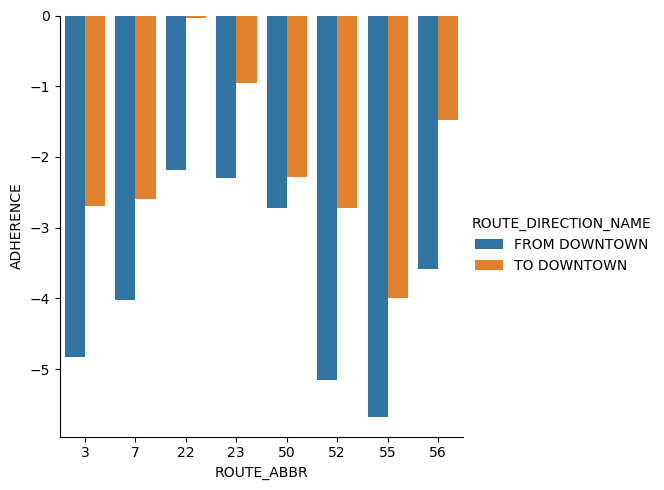

In [84]:
sns.catplot(x='ROUTE_ABBR', y='ADHERENCE', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_adherence_df, kind='bar')
plt.show()

In [40]:
route_v_dir_adherence_df = route_v_dir_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWAY_DEV', '', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
route_v_dir_adherence_df.head(20)

BLOCK_ABBR  ROUTE_STOP_SEQUENCE  TRIP_EDGE  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                                
3          FROM DOWNTOWN          307.911501             4.455603   0.543552   
           TO DOWNTOWN            307.323707             4.435437   0.547125   
7          FROM DOWNTOWN          702.291680             4.000000   0.998910   
           TO DOWNTOWN            777.445285             3.986900   1.000113   
22         FROM DOWNTOWN         2203.612115             6.285405   0.850911   
           TO DOWNTOWN           2239.345557             5.412060   0.915043   
23         FROM DOWNTOWN         2309.249872             4.660836   0.525765   
           TO DOWNTOWN           2308.204671             3.499911   0.749806   
50         FROM DOWNTOWN         5027.125869            14.462879   0.506025   
           TO DOWNTOWN           5018.351034            14.380694   0.512965   
52         FROM DOWNTOWN         5208.139003             5.843816   0.496271   
           TO DOWNTOWN           5207.876196             4.608203   0.536671   
55         FROM DOWNTOWN         5505.248201             8.160725   0.501156   
           TO DOWNTOWN           5515.700740             8.115413   0.512633   
56         FROM DOWNTOWN         5605.065429             9.850021   0.429644   
           TO DOWNTOWN           5601.838912             8.773125   0.604599   

                                 ADHERENCE  SCHEDULED_HDWY  ACTUAL_HDWY  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                           
3          FROM DOWNTOWN         -4.831550       17.961717    18.641661   
           TO DOWNTOWN           -2.689360       21.096939    21.627054   
7          FROM DOWNTOWN         -4.028927       22.923064    23.338300   
           TO DOWNTOWN           -2.599183       22.642276    22.978687   
22         FROM DOWNTOWN         -2.179503       26.816186    27.289011   
           TO DOWNTOWN           -0.041538       33.550627    34.276775   
23         FROM DOWNTOWN         -2.295042       19.588134    20.496135   
           TO DOWNTOWN           -0.959462       16.620123    17.523705   
50         FROM DOWNTOWN         -2.729163       19.590368    19.831437   
           TO DOWNTOWN           -2.282192       19.467382    19.675972   
52         FROM DOWNTOWN         -5.149382       18.526079    19.713565   
           TO DOWNTOWN           -2.723518       21.585263    22.078139   
55         FROM DOWNTOWN         -5.673887       13.718148    13.993384   
           TO DOWNTOWN           -3.989490       13.445850    13.725681   
56         FROM DOWNTOWN         -3.579404       13.993881    14.178556   
           TO DOWNTOWN           -1.484165       13.968544    14.128893   

                                 HDWY_DEV  ADJUSTED_EARLY_COUNT  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                   
3          FROM DOWNTOWN         0.636069              0.027019   
           TO DOWNTOWN           0.525802              0.031601   
7          FROM DOWNTOWN         0.379082              0.032494   
           TO DOWNTOWN           0.293108              0.015246   
22         FROM DOWNTOWN         1.088609              0.027861   
           TO DOWNTOWN           0.808517              0.020523   
23         FROM DOWNTOWN         1.063912              0.024837   
           TO DOWNTOWN           1.038711              0.039147   
50         FROM DOWNTOWN         0.222529              0.030633   
           TO DOWNTOWN           0.202238              0.025146   
52         FROM DOWNTOWN         1.238860              0.032728   
           TO DOWNTOWN           0.690182              0.026980   
55         FROM DOWNTOWN         0.264152              0.026142   
           TO DOWNTOWN           0.257969              0.023313   
56         FROM DOWNTOWN         0.158441              0.028731   
           TO DOWNTOWN           0.135393              0.029834   

                                 AD

In [ ]:
# maybe split the direction column into 2 first?


In [52]:
# plt.bar(data=route_v_dir_adherence_df, x='ROUTE_ABBR', align='edge', width=0.4) 
# plt.bar(data=route_v_dir_adherence_df, x='ROUTE_DIRECTION_NAME', align='edge', width=0.4) 

route_v_dir_adherence_df.plot(x='ROUTE_DIRECTION_NAME', 
        kind='bar', 
        stacked=False, 
        title='Adherence by Bus and Direction') 

plt.show()

KeyError: 'ROUTE_DIRECTION_NAME'

In [26]:
# new combo - dir v loc
loc_v_dir_adherence_df = wego.groupby(['BLOCK_ABBR', 'ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
loc_v_dir_adherence_df.head(20)

CALENDAR_ID  SERVICE_ABBR  ADHERENCE_ID  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                             
300        FROM DOWNTOWN         1.202309e+08      1.449156  1.001056e+08   
           TO DOWNTOWN           1.202309e+08      1.454442  1.001061e+08   
301        FROM DOWNTOWN         1.202309e+08      1.496158  1.001039e+08   
           TO DOWNTOWN           1.202309e+08      1.504244  1.001065e+08   
302        FROM DOWNTOWN         1.202309e+08      1.000000  1.000935e+08   
           TO DOWNTOWN           1.202309e+08      1.000000  1.000935e+08   
303        FROM DOWNTOWN         1.202309e+08      1.000000  1.000931e+08   
           TO DOWNTOWN           1.202309e+08      1.000000  1.000937e+08   
304        FROM DOWNTOWN         1.202309e+08      1.000000  1.000914e+08   
           TO DOWNTOWN           1.202309e+08      1.000000  1.000914e+08   
305        FROM DOWNTOWN         1.202309e+08      1.000000  1.000933e+08   
           TO DOWNTOWN           1.202309e+08      1.000000  1.000937e+08   
310        FROM DOWNTOWN         1.202309e+08      1.976000  1.001217e+08   
           TO DOWNTOWN           1.202309e+08      1.973298  1.001216e+08   
311        FROM DOWNTOWN         1.202309e+08      1.401622  1.001060e+08   
           TO DOWNTOWN           1.202309e+08      1.402542  1.001060e+08   
312        FROM DOWNTOWN         1.202309e+08      2.142506  1.001244e+08   
           TO DOWNTOWN           1.202309e+08      2.141463  1.001243e+08   
313        FROM DOWNTOWN         1.202309e+08      1.000000  1.000928e+08   
           TO DOWNTOWN           1.202309e+08      1.000000  1.000939e+08   

                                 ROUTE_ABBR     OPERATOR        TRIP_ID  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                           
300        FROM DOWNTOWN                3.0  2251.555062  350671.213810   
           TO DOWNTOWN                  3.0  2218.384055  350670.424829   
301        FROM DOWNTOWN                3.0  2185.536585  350747.875376   
           TO DOWNTOWN                  3.0  2137.695076  350765.938879   
302        FROM DOWNTOWN                3.0  1294.186047  350695.953488   
           TO DOWNTOWN                  3.0  1335.418605  350694.953488   
303        FROM DOWNTOWN                3.0  1179.323201  350712.405541   
           TO DOWNTOWN                  3.0  1196.302703  350710.266409   
304        FROM DOWNTOWN                3.0  2610.632184  350727.816092   
           TO DOWNTOWN                  3.0  2610.632184  350726.816092   
305        FROM DOWNTOWN                3.0  2378.704935  350731.445116   
           TO DOWNTOWN                  3.0  2378.093023  350729.135307   
310        FROM DOWNTOWN                3.0  1887.900000  350970.048000   
           TO DOWNTOWN                  3.0  1828.801736  350968.871829   
311        FROM DOWNTOWN                3.0  1933.267278  350879.584626   
           TO DOWNTOWN                  3.0  1700.991525  350878.250000   
312        FROM DOWNTOWN                3.0  2216.825553  351099.759214   
           TO DOWNTOWN                  3.0  2145.640650  351099.317073   
313        FROM DOWNTOWN                3.0  1998.546017  350861.730858   
           TO DOWNTOWN                  3.0  2034.742248  350860.953488   

                                 OVERLOAD_ID  ROUTE_STOP_SEQUENCE  TRIP_EDGE  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                                
300        FROM DOWNTOWN            0.008881             4.080817   0.584591   
           TO DOWNTOWN              0.009112             4.000000   0.599089   
301        FROM DOWNTOWN            0.014033             4.074173   0.590043   
           TO DOWNTOWN              0.008489             4.000000   0.598642   
302        FROM DOWNTOWN            0.000000             4.000000   0.600000   
           TO DOWNTOWN              0.000000             4.000000   0.600000   
303        FROM DOWNTOWN            0.007311    

In [27]:
loc_v_dir_adherence_df.info() #see what columns i currently have

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 187 entries, (300, 'FROM DOWNTOWN') to (9975, 'TO DOWNTOWN')
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CALENDAR_ID                187 non-null    float64
 1   SERVICE_ABBR               187 non-null    float64
 2   ADHERENCE_ID               187 non-null    float64
 3   ROUTE_ABBR                 187 non-null    float64
 4   OPERATOR                   187 non-null    float64
 5   TRIP_ID                    187 non-null    float64
 6   OVERLOAD_ID                187 non-null    float64
 7   ROUTE_STOP_SEQUENCE        187 non-null    float64
 8   TRIP_EDGE                  187 non-null    float64
 9   LATITUDE                   187 non-null    float64
 10  LONGITUDE                  187 non-null    float64
 11  ADHERENCE                  187 non-null    float64
 12  SCHEDULED_HDWY             181 non-null    float64
 13  ACTUAL_HDWY

In [28]:
loc_v_dir_adherence_df = loc_v_dir_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'TRIP_EDGE', 'OVERLOAD_ID', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
loc_v_dir_adherence_df.head(20)

ROUTE_ABBR  ROUTE_STOP_SEQUENCE  ADHERENCE  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                               
300        FROM DOWNTOWN                3.0             4.080817  -5.101584   
           TO DOWNTOWN                  3.0             4.000000  -2.583756   
301        FROM DOWNTOWN                3.0             4.074173  -3.951243   
           TO DOWNTOWN                  3.0             4.000000  -2.148728   
302        FROM DOWNTOWN                3.0             4.000000  -4.533100   
           TO DOWNTOWN                  3.0             4.000000  -1.213668   
303        FROM DOWNTOWN                3.0             4.000770  -6.240231   
           TO DOWNTOWN                  3.0             4.000000  -4.175188   
304        FROM DOWNTOWN                3.0             4.000000  -6.370689   
           TO DOWNTOWN                  3.0             4.000000  -3.992432   
305        FROM DOWNTOWN                3.0             4.647533  -5.363281   
           TO DOWNTOWN                  3.0             4.454545  -3.790114   
310        FROM DOWNTOWN                3.0             4.833333  -4.745819   
           TO DOWNTOWN                  3.0             4.829773  -3.151491   
311        FROM DOWNTOWN                3.0             4.835331  -4.835012   
           TO DOWNTOWN                  3.0             4.833333  -2.565768   
312        FROM DOWNTOWN                3.0             4.802621  -3.434701   
           TO DOWNTOWN                  3.0             4.833333  -2.245046   
313        FROM DOWNTOWN                3.0             4.837587  -2.473344   
           TO DOWNTOWN                  3.0             4.833333  -1.200376   

                                 SCHEDULED_HDWY  ACTUAL_HDWY  HDWY_DEV  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                          
300        FROM DOWNTOWN              20.097892    20.911199  0.574595   
           TO DOWNTOWN                23.644914    23.687298  0.071502   
301        FROM DOWNTOWN              15.576779    15.638927 -0.013471   
           TO DOWNTOWN                18.923599    19.220619  0.232348   
302        FROM DOWNTOWN              12.500000    12.771366  0.271366   
           TO DOWNTOWN                15.500000    16.230799  0.760039   
303        FROM DOWNTOWN              17.119288    19.345161  2.279933   
           TO DOWNTOWN                19.891892    22.088568  2.218746   
304        FROM DOWNTOWN               9.382184     9.370419 -0.016998   
           TO DOWNTOWN                12.120690    13.376590  1.251590   
305        FROM DOWNTOWN              17.643118    18.061640  0.431613   
           TO DOWNTOWN                21.277778    22.829357  1.290785   
310        FROM DOWNTOWN              23.042607    25.109599  2.016895   
           TO DOWNTOWN                25.884413    28.093727  2.052509   
311        FROM DOWNTOWN              19.716039    20.493009  0.817487   
           TO DOWNTOWN                22.733051    22.991255  0.319244   
312        FROM DOWNTOWN              22.946375    24.603821  1.772908   
           TO DOWNTOWN                26.896723    27.778157  1.014182   
313        FROM DOWNTOWN              15.732591    13.912212 -1.809052   
           TO DOWNTOWN                18.100000    16.946270 -1.125953   

                                 ADJUSTED_EARLY_COUNT  ADJUSTED_LATE_COUNT  \
BLOCK_ABBR ROUTE_DIRECTION_NAME                                              
300        FROM DOWNTOWN                     0.031528             0.291297   
           TO DOWNTOWN                       0.037813             0.142141   
301        FROM DOWNTOWN                     0.022386             0.210157   
           TO DOWNTOWN                       0.037351             0.094397   
302        FROM DOWNTOWN                     0.002326             0.262791   
           TO DOWNTOWN                       0.013953             0.058140   
303        FROM DOWNTOWN                 

Observe that the dir v block combination all fall within or close to the safe range 

In [30]:
# loc v route
loc_v_route_adherence_df = wego.groupby(['BLOCK_ABBR', 'ROUTE_ABBR']).mean(['ADHERENCE'])
loc_v_route_adherence_df.head(20)

,,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
BLOCK_ABBR,ROUTE_ABBR,,,,,,,,,,,,,,,,,,,,,
300,3,1.202309e+08,1.451765,1.001059e+08,2235.182145,350670.824376,0.008995,4.040926,0.591747,36.146048,-86.822489,...,22.290352,0.322731,0.034630,0.217675,0.711716,0.018327,0.011631,0.014392,2.105501,12.161010
301,3,1.202309e+08,1.500168,1.001052e+08,2161.809195,350756.834119,0.011283,4.037386,0.594308,36.145802,-86.822608,...,17.416645,0.108538,0.029808,0.152745,0.788313,0.018188,0.013658,0.010273,2.261899,10.636161
302,3,1.202309e+08,1.000000,1.000935e+08,1314.802326,350695.453488,0.000000,4.000000,0.600000,36.146895,-86.821044,...,14.496040,0.514990,0.008140,0.160465,0.829070,0.004651,0.011628,0.002326,2.723271,8.196581
303,3,1.202309e+08,1.000000,1.000934e+08,1187.798227,350711.337830,0.005589,4.000385,0.599345,36.146891,-86.821051,...,20.713154,2.249422,0.013297,0.304490,0.659665,0.010407,0.006745,0.010214,2.372611,12.862884
304,3,1.202309e+08,1.000000,1.000914e+08,2610.632184,350727.316092,0.028736,4.000000,0.597701,36.146895,-86.821044,...,11.380115,0.619389,0.033333,0.245977,0.591954,0.044828,0.025862,0.000000,2.479331,10.729167
305,3,1.202309e+08,1.000000,1.000935e+08,2378.406395,350730.318205,0.002063,4.553378,0.533265,36.130587,-86.844321,...,20.369663,0.847533,0.042806,0.258896,0.600309,0.015988,0.011920,0.000000,2.358481,14.637555
310,3,1.202309e+08,1.974650,1.001217e+08,1858.370580,350969.460307,0.007338,4.831554,0.498999,36.122417,-86.855999,...,26.569611,2.034319,0.022682,0.215811,0.726818,0.020680,0.018014,0.006004,3.013574,15.794721
311,3,1.202309e+08,1.402082,1.001060e+08,1817.211362,350878.917784,0.004940,4.834333,0.499471,36.122370,-86.856084,...,21.745388,0.567716,0.012174,0.188250,0.773994,0.012174,0.010375,0.011291,2.570303,14.765873
312,3,1.202309e+08,2.141983,1.001243e+08,2181.102407,351099.537332,0.000000,4.818033,0.501836,36.122836,-86.855415,...,26.192634,1.393152,0.013872,0.124847,0.820481,0.015504,0.013229,0.011424,2.884241,13.843137


In [31]:
loc_v_route_adherence_df.info() #see what columns i currently have

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 104 entries, (300, 3) to (9975, 56)
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CALENDAR_ID                104 non-null    float64
 1   SERVICE_ABBR               104 non-null    float64
 2   ADHERENCE_ID               104 non-null    float64
 3   OPERATOR                   104 non-null    float64
 4   TRIP_ID                    104 non-null    float64
 5   OVERLOAD_ID                104 non-null    float64
 6   ROUTE_STOP_SEQUENCE        104 non-null    float64
 7   TRIP_EDGE                  104 non-null    float64
 8   LATITUDE                   104 non-null    float64
 9   LONGITUDE                  104 non-null    float64
 10  ADHERENCE                  104 non-null    float64
 11  SCHEDULED_HDWY             98 non-null     float64
 12  ACTUAL_HDWY                99 non-null     float64
 13  HDWY_DEV                   98 non-nu

In [56]:
# loc_v_route_adherence_df = loc_v_route_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'TRIP_EDGE', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
# loc_v_route_adherence_df.head(20)

#not sure what's happening here but not sure i'm going to use this much anyway

In [58]:
#can we look at all three factors at once?
full_adherence_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'BLOCK_ABBR']).mean(['ADHERENCE'])
full_adherence_df.head(20)

CALENDAR_ID  SERVICE_ABBR  \
ROUTE_ABBR ROUTE_DIRECTION_NAME BLOCK_ABBR                               
3          FROM DOWNTOWN        300         1.202309e+08      1.449156   
                                301         1.202309e+08      1.496158   
                                302         1.202309e+08      1.000000   
                                303         1.202309e+08      1.000000   
                                304         1.202309e+08      1.000000   
                                305         1.202309e+08      1.000000   
                                310         1.202309e+08      1.976000   
                                311         1.202309e+08      1.401622   
                                312         1.202309e+08      2.142506   
                                313         1.202309e+08      1.000000   
                                314         1.202309e+08      1.000000   
                                315         1.202309e+08      1.000000   
                                316         1.202309e+08      1.000000   
                                317         1.202309e+08      1.000000   
                                318         1.202309e+08      1.000000   
                                319         1.202309e+08      1.000000   
                                390         1.202309e+08      1.000000   
           TO DOWNTOWN          300         1.202309e+08      1.454442   
                                301         1.202309e+08      1.504244   
                                302         1.202309e+08      1.000000   

                                            ADHERENCE_ID     OPERATOR  \
ROUTE_ABBR ROUTE_DIRECTION_NAME BLOCK_ABBR                              
3          FROM DOWNTOWN        300         1.001056e+08  2251.555062   
                                301         1.001039e+08  2185.536585   
                                302         1.000935e+08  1294.186047   
                                303         1.000931e+08  1179.323201   
                                304         1.000914e+08  2610.632184   
                                305         1.000933e+08  2378.704935   
                                310         1.001217e+08  1887.900000   
                                311         1.001060e+08  1933.267278   
                                312         1.001244e+08  2216.825553   
                                313         1.000928e+08  1998.546017   
                                314         1.000956e+08  2144.513825   
                                315         1.000944e+08  2195.881944   
                                316         1.000941e+08  2964.441860   
                                317         1.000954e+08   704.580521   
                                318         1.000898e+08  2256.543478   
                                319         1.000942e+08  2758.534884   
                                390         1.001684e+08  1920.323529   
           TO DOWNTOWN          300         1.001061e+08  2218.384055   
                                301         1.001065e+08  2137.695076   
                                302         1.000935e+08  1335.418605   

                                                  TRIP_ID  OVERLOAD_ID  \
ROUTE_ABBR ROUTE_DIRECTION_NAME BLOCK_ABBR                               
3          FROM DOWNTOWN        300         350671.213810     0.008881   
                                301         350747.875376     0.014033   
                                302         350695.953488     0.000000   
                                303         350712.405541     0.007311   
                                304         350727.816092     0.034483   
                                305         350731.445116     0.004028   
                                310         350970.048000     0.008000   
                                311         350879.584626     0.005642   
                                312         351099.759214     0.00000

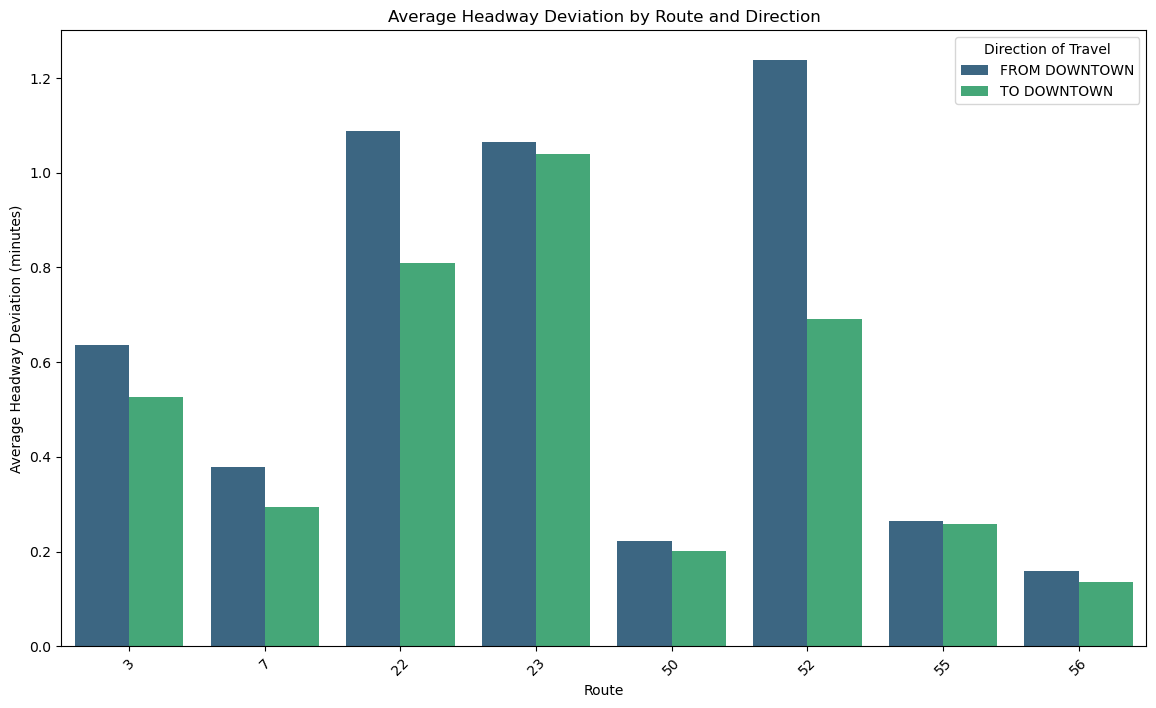

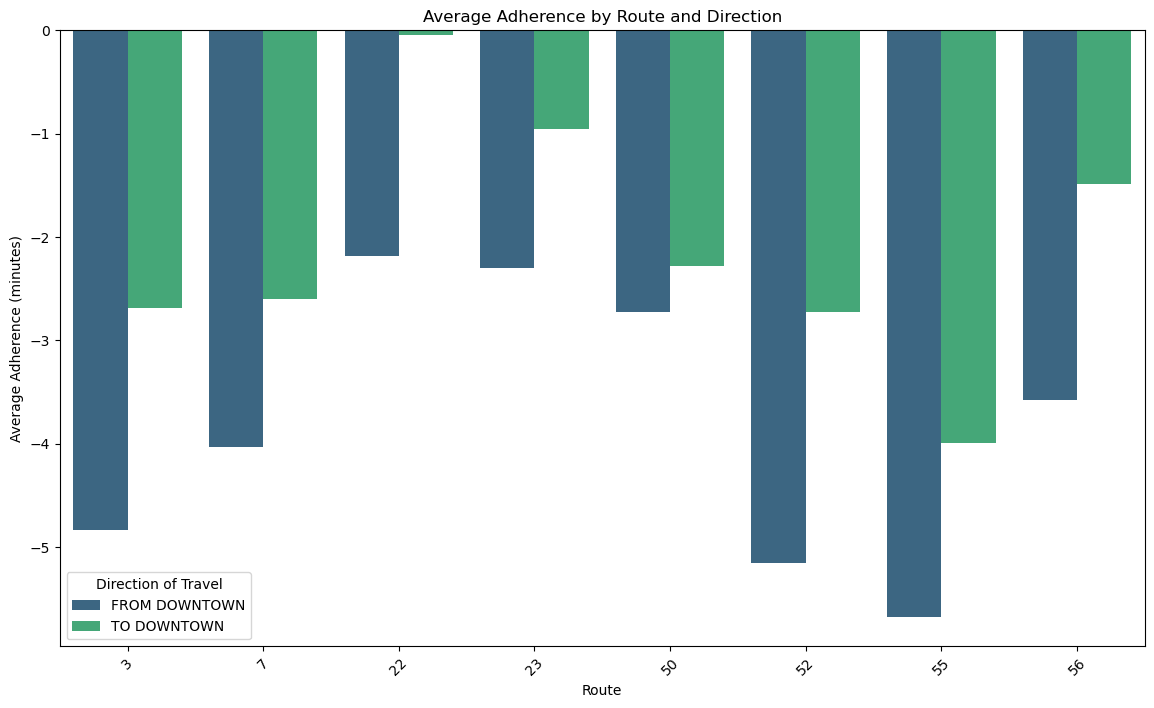

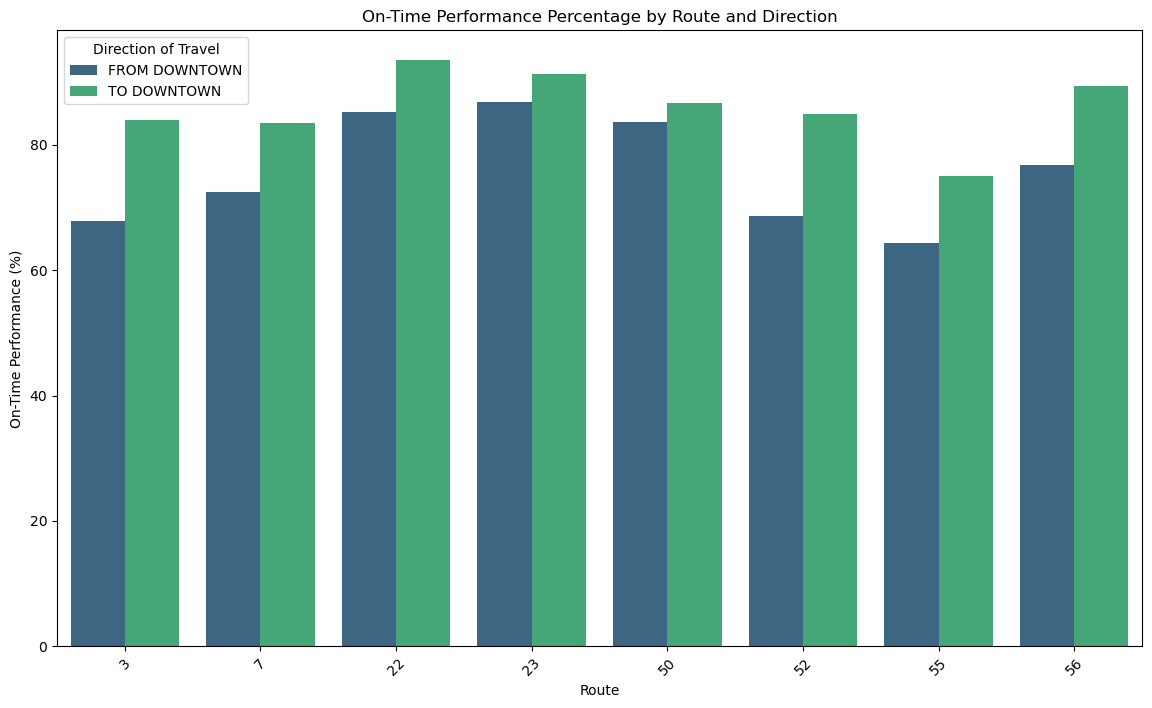

In [90]:
# Calculate average headway deviation and on-time performance
route_v_dir_performance_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).agg({
    'HDWY_DEV': 'mean', # avg headway dev for bus and direction combo
    'ADHERENCE': 'mean', # avg adherence for bus and direction combo
    'ADJUSTED_ONTIME_COUNT': 'sum', # number of times that bus and dir combo is on time 
    'ADJUSTED_LATE_COUNT': 'sum', # number of times that bus and dir combo is late
    'ADJUSTED_EARLY_COUNT': 'sum' # number of times that bus and dir combo is early 
}).reset_index()

# Calculate on-time percentage for each combination of route and direction
route_v_dir_performance_df['on_time_percentage'] = (
    route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] /
    (route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_LATE_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_EARLY_COUNT'])
) * 100

# Plot average headway deviation by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='HDWY_DEV', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('Average Headway Deviation by Route and Direction')
plt.xlabel('Route')
plt.ylabel('Average Headway Deviation (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

# Plot average adherence by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='ADHERENCE', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('Average Adherence by Route and Direction')
plt.xlabel('Route')
plt.ylabel('Average Adherence (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

# Plot on-time performance percentage by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='on_time_percentage', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('On-Time Performance Percentage by Route and Direction')
plt.xlabel('Route')
plt.ylabel('On-Time Performance (%)')
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

3. How does time of day or day of week affect headway and on-time performance?


4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?
